# 📚 <span style='color:#0D2BA5'>**Projet de Scoring de Crédit pour "Prêt à Dépenser"**

### <span style='color:#0D2BA5'>**Partie 02: Optimisation du Modèle en Gérant le Déséquilibre de Classe et les Coûts d'Erreur**

# <font color='DodgerBlue'>SOMMAIRE<font></a>
    
### <a href="#C1"><font color='DodgerBlue'> 1. Préparation des données </a>
******
   - <a href="#C2"><font color='RoyalBlue'>**1.1 Import des bibliothèques necessaires et fonctions utiles** </a>
******
### <a href="#C3"><font color='DodgerBlue'>2. Chargement des données,datasplit, standardisation </a>
******    
### <a href="#C4"><font color='DodgerBlue'>3. Stratégie de Rééquilibrage des Classes </a>
******
### <a href="#C5"><font color='DodgerBlue'>4. Business score </a>
******
### <a href="#C6"><font color='DodgerBlue'>5. MLFLOW Tracking </a>
******
### <a href="#C7"><font color='DodgerBlue'>6. Modélisation </a>
******
   - <a href="#C8"><font color='RoyalBlue'>**6.1 Classification avec des données déséquilibrées**</a>
******
   - <a href="#C9"><font color='RoyalBlue'>**6.1.1 DummyClassifier (données déséquilibrées)**</a>
   - <a href="#C10"><font color='RoyalBlue'>**6.1.2 Regression logistique (données déséquilibrées)**</a>
   - <a href="#C11"><font color='RoyalBlue'>**6.1.3 LightGBM (données déséquilibrées)**</a>
   - <a href="#C12"><font color='RoyalBlue'>**6.1.4 RandomForest Classifier (données déséquilibrées)**</a>
******
  - <a href="#C13"><font color='RoyalBlue'>**6.2 Classification avec des données rééquilibrées (SMOTE)**</a>
*****
   - <a href="#C14"><font color='RoyalBlue'>**6.2.1 DummyClassifier (rééquilibré avec SMOTE)**</a>
   - <a href="#C15"><font color='RoyalBlue'>**6.2.2 Regression logistique (données rééquilibrées avec SMOTE)**</a>
   - <a href="#C16"><font color='RoyalBlue'>**6.2.3 LightGBM (données rééquilibrées avec SMOTE)**</a>
   - <a href="#C17"><font color='RoyalBlue'>**6.2.4 RandomForest Classifier (données rééquilibrées avec SMOTE)**</a>
*****
 - <a href="#C18"><font color='RoyalBlue'>**6.3 Choix du meilleur modèle**</a>
 - <a href="#C19"><font color='RoyalBlue'>**6.4 Optimisation et Ajustement du Meilleur Modèle**</a>
 - <a href="#C20"><font color='RoyalBlue'>**6.5 Features importance**</a>
 - <a href="#C21"><font color='RoyalBlue'>**6.6 Sauvegarder le modèle**</a>
*****
*****

## <a name="C1"><span style='background:PowderBlue'> 1. Préparation des données</a>

**1. Gérer le Déséquilibre de Classe :**

Le dataset peut contenir un déséquilibre entre les classes, c’est-à-dire un nombre disproportionné de bons clients par rapport aux mauvais clients.
Pour remédier à cela, on peut utiliser des techniques comme le SMOTE (Synthetic Minority Over-sampling Technique) ou le class weighting pour rééquilibrer les classes.
****
**2. Prendre en Compte les Coûts Métier Associés aux Erreurs de Prédiction :**

Différentes erreurs de prédiction (faux positifs et faux négatifs) ont des impacts financiers différents.
Un faux négatif (mauvais client prédit bon) entraîne une perte financière importante (capital non remboursé).
Un faux positif (bon client prédit mauvais) entraîne un manque à gagner (crédit refusé).
Hypothèse : le coût d’un faux négatif est dix fois supérieur à celui d’un faux positif.
****
**3. Définir un Score Métier :**

Créer une fonction de coût qui tient compte des coûts différenciés des faux négatifs et des faux positifs.
Optimiser ce score pour choisir le meilleur modèle et les meilleurs hyperparamètres.
****
**4. Optimiser le Seuil de Décision :**

Le seuil de classification par défaut est souvent 0,5, mais il n’est pas toujours optimal.
Ajuster le seuil pour minimiser le coût métier, plutôt que de se baser uniquement sur l’accuracy.
****
**5. Évaluer les Performances du Modèle :**

Utiliser plusieurs métriques pour évaluer le modèle de classification binaire, notamment :
- AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) : Mesure de la capacité du modèle à distinguer les classes.
- Accuracy : Proportion de prédictions correctes par rapport au total.
- Précision (Precision) : Proportion de vrais positifs parmi les prédictions positives.
- Rappel (Recall) : Proportion de vrais positifs parmi les cas réellement positifs.
- F1-Score : Moyenne harmonique entre la précision et le rappel, utile pour des datasets déséquilibrés.
- Matric de Confusion : Visualisation des vrais positifs, vrais négatifs, faux positifs et faux négatifs.

### <a name="C2"><font color='RoyalBlue'> 1.1 Import des bibliothèques necessaires et fonctions utiles</a>

In [6]:
# Gestion du système de fichiers
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
import time
import joblib

# Scikit-learn & Modèles
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.model_selection import (cross_val_predict, cross_validate, cross_val_score, 
                                     train_test_split, GridSearchCV, RandomizedSearchCV, 
                                     StratifiedKFold, RepeatedStratifiedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, f1_score, accuracy_score, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier

import xgboost as xgb
import lightgbm as ltb
from lightgbm import plot_importance

from sklearn.utils import shuffle

# Équilibrage des données
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Interprétation des caractéristiques
import shap

# MLFlow
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifacts
from mlflow.models.signature import infer_signature

# Gestion des avertissements
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message=".*Git.*")
warnings.filterwarnings('ignore', message=".*model signature.*")
warnings.filterwarnings('ignore')

In [7]:
import sys
# Rediriger stderr vers un fichier (optionnel)
sys.stderr = open(os.devnull, 'w')

# Ou pour rediriger uniquement les messages Git
sys.stderr.write = lambda s: None if "git" in s.lower() else sys.__stderr__.write(s)

In [8]:
# Fonction matrice de confusion
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [9]:
# Fonction courbe ROC AUC
def compute_roc_curve(y_test, y_pred_proba, 
                      model_name="Model", 
                      disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', 
                 label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], 
                        y=[o_tpr], 
                        legend='brief', 
                        label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('Taux vrais positifs')
    plt.xlabel('Taux faux positifs')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [10]:
# Fonction : MLFlow génération métriques
def log_mlflow(model, name, custom_score, n_estimator=None, 
               max_depth=None, auc_score=None, f1_score=None, 
               acc_score=None, train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

In [11]:
# Fonction : business score
def business_loss_func(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

In [12]:
#Fonction pour évaluer les performances d'un modèle de classification en utilisant plusieurs métriques
def compute_classification_results(model, model_name, x_test, y_test):

    # Prédiction target == 1 (incident de paiement)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    y_pred = model.predict(x_test)

    # Matrice de confusion
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Courbe ROC
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Calcul des scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Business Loss Function
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

In [13]:
# Fonction : features importance
def display_importances(feature_importance_df_):
    
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [14]:
# Paramètres généraux modélisation (split rate + random_state)
split_rate = 0.8
rs = 42

# Encodage
scaler = preprocessing.StandardScaler()

## <a name="C3"><span style='background:PowderBlue'> 2. Chargement des données,datasplit, standardisation</a>

In [16]:
# Charger le fichier CSV
df = pd.read_csv('data_cleaned.csv')

# Afficher les premières lignes pour vérifier le contenu
print("Les premières lignes du DataFrame :")
print(df.head())

# Séparer les features (X) et la cible (y)
X = df.drop(columns=['TARGET'])
y = df['TARGET']
# Diviser les données en jeux d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = split_rate,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = rs)
# Définition de la liste des features de X
features_names = X_train.columns.to_list()

# Affichage des formats post splits
display(f'Format de X_train : {X_train.shape}')
display(f'Format de X_test : {X_test.shape}')
display(f'Format de y_train : {y_train.shape}')
display(f'Format de y_test : {y_test.shape}')

Les premières lignes du DataFrame :
   SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1            0             0                0   
1      100003       0            1             0                1   
2      100004       0            0             1                0   
3      100006       0            1             0                0   
4      100007       0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             0          202500.0    406597.5      24700.5   
1             0          270000.0   1293502.5      35698.5   
2             0           67500.0    135000.0       6750.0   
3             0          135000.0    312682.5      29686.5   
4             0          121500.0    513000.0      21865.5   

   REGION_POPULATION_RELATIVE  ...  INSTAL_PAYMENT_PERC_MEAN  \
0                    0.018801  ...                  1.000000   
1                    0.003541  ...              

'Format de X_train : (285000, 413)'

'Format de X_test : (71251, 413)'

'Format de y_train : (285000,)'

'Format de y_test : (71251,)'

In [17]:
# Formats des Dataset
display(f'Format de X (features) : {X.shape}')
display(f'Format de y (target) : {y.shape}')

'Format de X (features) : (356251, 413)'

'Format de y (target) : (356251,)'

In [18]:
# Standardisation
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## <a name="C4"><span style='background:PowderBlue'> 3. Stratégie de Rééquilibrage des Classes</a>

**Dans cette section, nous allons utiliser la méthode SMOTE (Synthetic Minority Over-sampling Technique) pour équilibrer les classes dans nos données.**
- SMOTE est une technique de rééchantillonnage spécifique pour gérer les ensembles de données déséquilibrés.

- SMOTE génère des échantillons synthétiques de la classe minoritaire en utilisant l'interpolation entre les échantillons existants. Pour chaque échantillon de la classe minoritaire, SMOTE sélectionne un certain nombre de ses voisins les plus proches appartenant à la même classe, puis génère de nouveaux échantillons en interpolant les attributs de l'échantillon original et de ses voisins.
- Nous appliquons SMOTE uniquement sur l'ensemble d'entraînement (X_train, y_train) au sein d'un pipeline, ce qui permet de ne pas altérer l'ensemble de test. Cette méthode évite les fuites de données, assurant une séparation claire entre les données d'entraînement et de test.

Répartition initiale de la target Y : Counter({0: 226145, 1: 19860})
Répartition finale de la target Y (avec SMOTE ajusté) : Counter({0: 84803, 1: 67843})


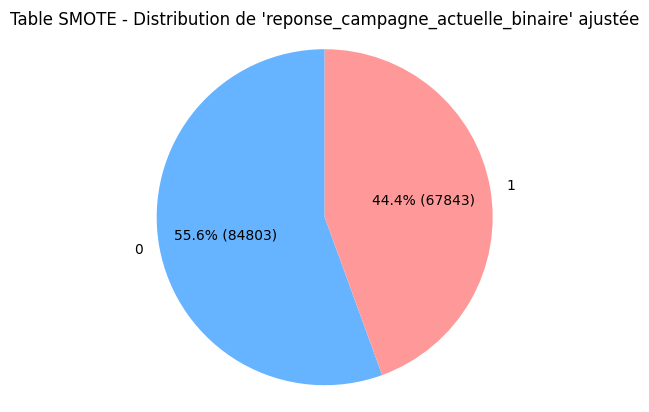

In [21]:
# Filtrer les valeurs non binaires
mask = y_train.isin([0, 1])
X_train_cleaned = X_train_scaled[mask]
y_train_cleaned = y_train[mask]

# Répartition initiale des classes
initial_counter = Counter(y_train_cleaned)
print(f'Répartition initiale de la target Y : {initial_counter}')

# Ajustement du pipeline SMOTE
seed = 21
# Ici, nous choisissons un sampling_strategy plus conservateur pour SMOTE
over = SMOTE(sampling_strategy=0.3, random_state=seed)  # Équilibrer légèrement la classe minoritaire
under = RandomUnderSampler(sampling_strategy=0.8, random_state=seed)  # Réduire un peu la classe majoritaire

# Construction du pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Application du pipeline au dataset
X_train_scaled_smote, y_train_smote = pipeline.fit_resample(X_train_cleaned, y_train_cleaned)

# Répartition après application de SMOTE et du sous-échantillonnage
smote_counter = Counter(y_train_smote)
print(f'Répartition finale de la target Y (avec SMOTE ajusté) : {smote_counter}')

# Fonction pour créer un pie chart avec les proportions et les nombres
def plot_pie_chart(y, title):
    labels = y.value_counts().index
    sizes = y.value_counts().values
    colors = ["#66b3ff", "#ff9999"]

    # Modifier le format des labels pour inclure les proportions et les nombres
    def autopct_format(pct, all_values):
        absolute = int(round(pct/100.*sum(all_values)))
        return f"{pct:.1f}% ({absolute})"

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes), startangle=90)
    ax.axis('equal')  # Pour assurer que le diagramme est bien rond
    plt.title(title)
    plt.show()

# Afficher la nouvelle distribution des données
plot_pie_chart(y_train_smote, "Table SMOTE - Distribution de 'reponse_campagne_actuelle_binaire' ajustée")

- Le rééchantillonnage SMOTE a réussi à équilibrer les classes de la variable cible TARGET dans l'ensemble de données. Avant l'application de SMOTE, il y avait une forte déséquilibre avec beaucoup plus de classes 0 (226145) par rapport aux classes 1 (19860). Après l'application de SMOTE, les classes 0 et 1 sont équilibrées à parts égales, avec chacune 113072 occurrences.
- Cela signifie que votre modèle aura désormais une meilleure capacité à apprendre à partir de données équilibrées, ce qui pourrait améliorer la performance pour la classe minoritaire lors de la prédiction.

## <a name="C5"><span style='background:PowderBlue'> 4. Business score</a>

Création d'un score "métier": Minimisation du coût d’erreur de prédiction des FN et FP

- Ce score permet de choisir le meilleur modèle et ses meilleurs hyperparamètres
****
**Attention:** Minimisation score métier -> optimisation du seuil qui détermine, la classe 0 ou 1
Un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum

In [25]:
business_score = make_scorer(business_loss_func, greater_is_better = False)

- Le code business_score = make_scorer(business_loss_func, greater_is_better = False) sert à créer une fonction de scoring personnalisée pour évaluer la performance d'un modèle de machine learning en utilisant un score métier spécifique.

## <a name="C6"><span style='background:PowderBlue'> 5. MLflow Tracking</a>

In [44]:
import subprocess

# Commande pour lancer le serveur MLflow
cmd = ["mlflow", "server", "--host", "127.0.0.1", "--port", "5000"]

# Lancer la commande
process = subprocess.Popen(cmd)

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Créer ou utiliser un expériment MLflow nommé "Scoring"
mlflow.set_experiment("Scoring")

<Experiment: artifact_location='mlflow-artifacts:/754511066962478635', creation_time=1722848104659, experiment_id='754511066962478635', last_update_time=1722848104659, lifecycle_stage='active', name='Scoring', tags={}>

In [46]:
'http://127.0.0.1:5000'

'http://127.0.0.1:5000'

- Ce code configure le suivi des expériences avec MLflow. La première ligne spécifie l'URI du serveur de suivi MLflow où les données de l'expérience seront enregistrées, tandis que la deuxième ligne crée un nouvel "expérience" MLflow nommé "Scoring" en utilisant un serveur de suivi local pour suivre les métriques et les modèles associés à ce projet.

## <a name="C7"><span style='background:PowderBlue'> 6. Modélisation</a>

### <a name="C8"><font color='RoyalBlue'> 6.1 Classification avec des données déséquilibrées</a>

- Lorsque nous travaillons avec des données déséquilibrées en classification, cela signifie que les classes cibles ne sont pas représentées de manière égale.

#### <a name="C9"><font color='Blue'>**6.1.1 DummyClassifier (données déséquilibrées)**</a>

- Le DummyClassifier est un modèle de base utilisé pour établir une référence de performance. Avec des données déséquilibrées, il prédit souvent la classe majoritaire sans tenir compte des caractéristiques des données, ce qui permet de comparer ses résultats à ceux de modèles plus avancés pour évaluer leur efficacité

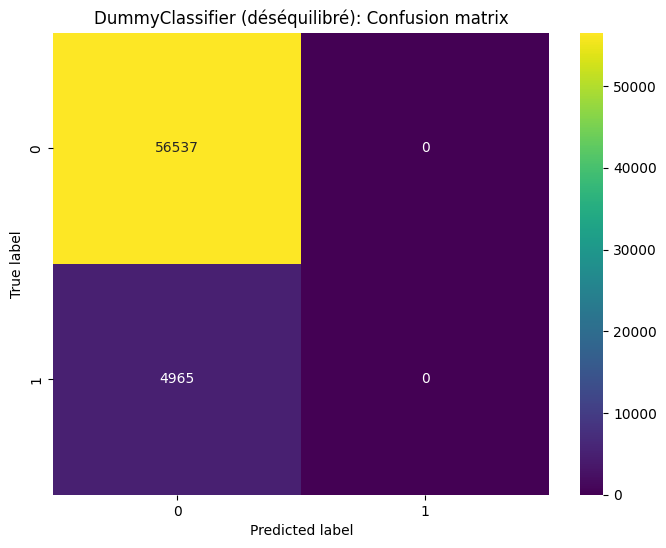

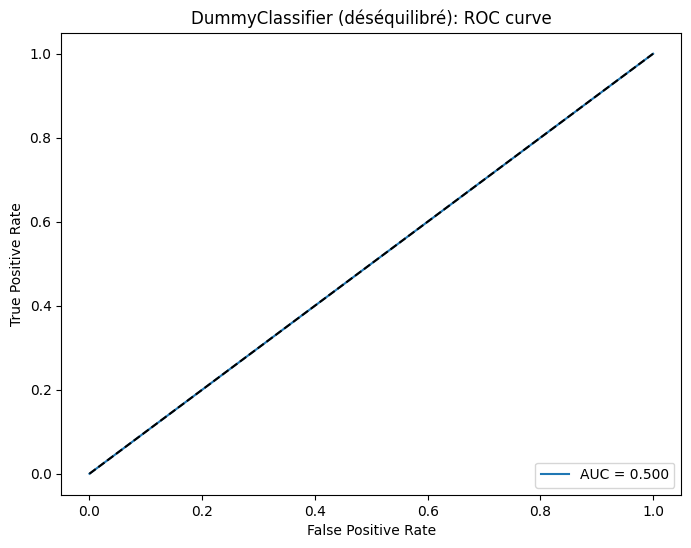

Business score = 49650
AUC: 0.500
                      0       1  accuracy     macro avg  weighted avg
precision      0.919271     0.0  0.919271      0.459635      0.845059
recall         1.000000     0.0  0.919271      0.500000      0.919271
f1-score       0.957938     0.0  0.919271      0.478969      0.880604
support    56537.000000  4965.0  0.919271  61502.000000  61502.000000


In [54]:
# Filtrer les classes pour ne garder que 0 et 1
mask = y_test.isin([0, 1])
y_test_binary = y_test[mask]
X_test_binary = X_test_scaled[mask]

# Entraîner le DummyClassifier
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_name = 'DummyClassifier (déséquilibré)'

# Entraînement du modèle
start_dummy = time.time()
dummy.fit(X_train_scaled, y_train)
end_dummy = time.time()
time_dummy = round(end_dummy - start_dummy, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = dummy.predict_proba(X_test_binary)[:, 1]
dummy_auc = roc_auc_score(y_test_binary, y_pred_proba) 

# Matrice de confusion
y_pred = dummy.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
dummy_report = classification_report(y_test_binary, y_pred, output_dict=True) 

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{dummy_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {dummy_auc:.3f}') 
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{dummy_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
dummy_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {dummy_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("DummyClassifier déséquilibré")
with mlflow.start_run():
    mlflow.log_param("Model", dummy_name)
    mlflow.log_param("Time to Train", time_dummy)
    mlflow.log_metric("AUC", dummy_auc)  
    mlflow.log_metric("Accuracy", dummy_report['accuracy']) 
    mlflow.log_metric("Business Score", dummy_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(dummy, dummy_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {dummy_auc:.3f}")
print(pd.DataFrame(dummy_report))

***Le DummyClassifier génère des prédictions basées sur des stratégies simples et statiques (comme prédire toujours la classe majoritaire ou prédire aléatoirement selon les proportions des classes). Contrairement aux modèles plus complexes, il ne calcule pas de probabilités et ne permet donc pas d’ajuster ses décisions en fonction d’un seuil. Cela le rend inadapté pour des analyses basées sur des probabilités, comme les courbes ROC, et il est principalement utilisé comme référence pour évaluer la performance des modèles plus sophistiqués.***

- ***Les résultats montrent que le modèle a une précision élevée (0,919) pour la classe majoritaire (0), mais il n'a fait aucune prédiction pour la classe minoritaire (1), ce qui conduit à une AUC très faible de 0,5 et à des scores de précision, rappel et f1-score de 0 pour la classe 1. Cela indique un problème de déséquilibre des classes que le modèle n'a pas su gérer, se concentrant uniquement sur la classe majoritaire.***

#### <a name="C10"><font color='Blue'>**6.1.2 Regression logistique (données déséquilibrées)**</a>

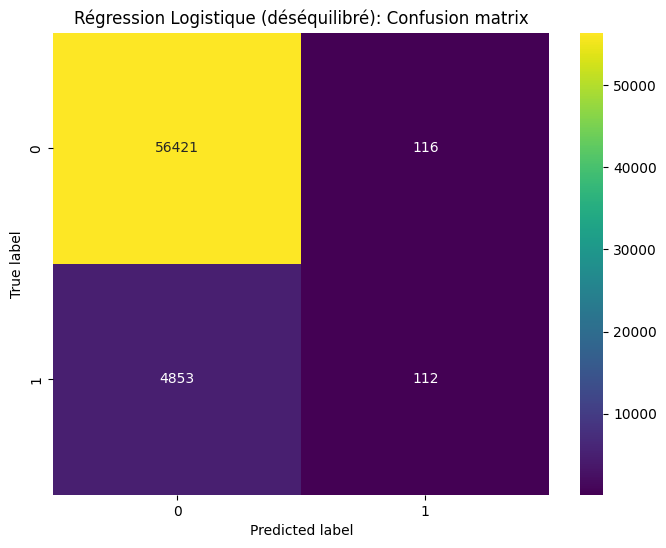

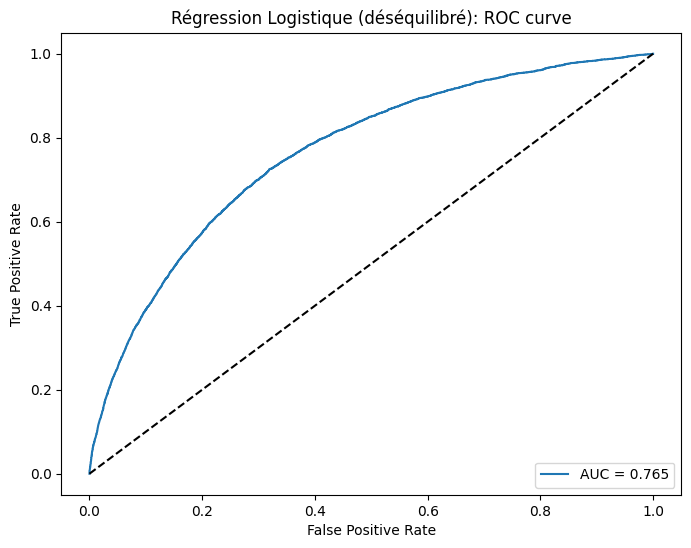

Business score = 48646
AUC: 0.765
                      0            1  accuracy     macro avg  weighted avg
precision      0.920798     0.491228  0.919206      0.706013      0.886120
recall         0.997948     0.022558  0.919206      0.510253      0.919206
f1-score       0.957822     0.043135  0.919206      0.500479      0.883980
support    56537.000000  4965.000000  0.919206  61502.000000  61502.000000


In [58]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données d'entraînement et de test
mask_train = y_train.isin([0, 1])
y_train_binary = y_train[mask_train]
X_train_binary = X_train_scaled[mask_train]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le modèle de régression logistique sur les données filtrées
logreg = LogisticRegression(random_state=42)
logreg_name = 'Régression Logistique (déséquilibré)'

# Entraînement du modèle
start_logreg = time.time()
logreg.fit(X_train_binary, y_train_binary)
end_logreg = time.time()
time_logreg = round(end_logreg - start_logreg, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = logreg.predict_proba(X_test_binary)[:, 1]
logreg_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = logreg.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
logreg_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{logreg_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {logreg_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{logreg_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
logreg_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {logreg_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("Logistic Regression déséquilibré")
with mlflow.start_run():
    mlflow.log_param("Model", logreg_name)
    mlflow.log_param("Time to Train", time_logreg)
    mlflow.log_metric("AUC", logreg_auc)
    mlflow.log_metric("Accuracy", logreg_report['accuracy'])
    mlflow.log_metric("Business Score", logreg_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(logreg, logreg_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {logreg_auc:.3f}")
print(pd.DataFrame(logreg_report))

***Le modèle de régression logistique montre une performance modérée avec une AUC de 0.765. Il prédit correctement la majorité des exemples négatifs (classe 0), mais a du mal à détecter les exemples positifs (classe 1), avec un rappel de 0.22. Le score métier est de 48 646, indiquant un coût significatif associé aux erreurs de prédiction, notamment les faux négatifs.***

#### <a name="C11"><font color='Blue'>**6.1.3 LightGBM (données déséquilibrées)**</a>

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30023
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469


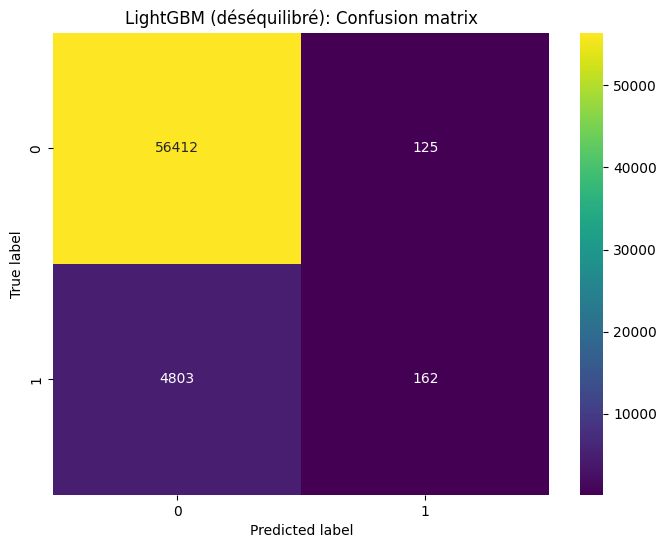

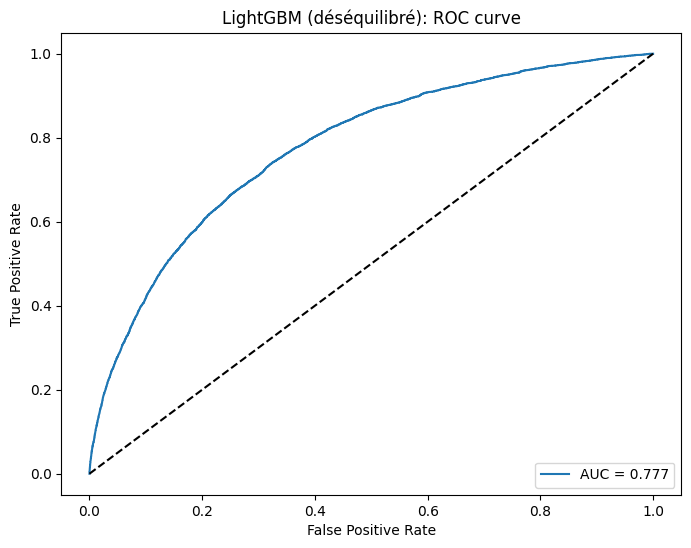

Business score = 48155
AUC: 0.777
                      0            1  accuracy     macro avg  weighted avg
precision      0.921539     0.564460  0.919873      0.742999      0.892712
recall         0.997789     0.032628  0.919873      0.515209      0.919873
f1-score       0.958149     0.061691  0.919873      0.509920      0.885779
support    56537.000000  4965.000000  0.919873  61502.000000  61502.000000


In [61]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données d'entraînement et de test
mask_train = y_train.isin([0, 1])
y_train_binary = y_train[mask_train]
X_train_binary = X_train_scaled[mask_train]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le modèle LightGBM sur les données filtrées
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm_name = 'LightGBM (déséquilibré)'

# Entraînement du modèle
start_lgbm = time.time()
lgbm.fit(X_train_binary, y_train_binary)
end_lgbm = time.time()
time_lgbm = round(end_lgbm - start_lgbm, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = lgbm.predict_proba(X_test_binary)[:, 1]
lgbm_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = lgbm.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
lgbm_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{lgbm_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {lgbm_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{lgbm_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
lgbm_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {lgbm_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("LightGBM déséquilibré")
with mlflow.start_run():
    mlflow.log_param("Model", lgbm_name)
    mlflow.log_param("Time to Train", time_lgbm)
    mlflow.log_metric("AUC", lgbm_auc)
    mlflow.log_metric("Accuracy", lgbm_report['accuracy'])
    mlflow.log_metric("Business Score", lgbm_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(lgbm, lgbm_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {lgbm_auc:.3f}")
print(pd.DataFrame(lgbm_report))

***Le modèle LightGBM  présente une capacité modérée à distinguer entre les classes, avec une AUC de 0,777. Cependant, il montre des difficultés à bien prédire la classe minoritaire, comme le démontre le grand nombre de faux négatifs (4803). Le score métier élevé (48155) indique que ce modèle entraîne des coûts importants en raison des erreurs de classification. En résumé, le modèle nécessite des ajustements pour améliorer la détection des cas positifs tout en minimisant les faux négatifs.***

#### <a name="C12"><font color='Blue'>**6.1.4 RandomForest Classifier (données déséquilibrées)**</a>

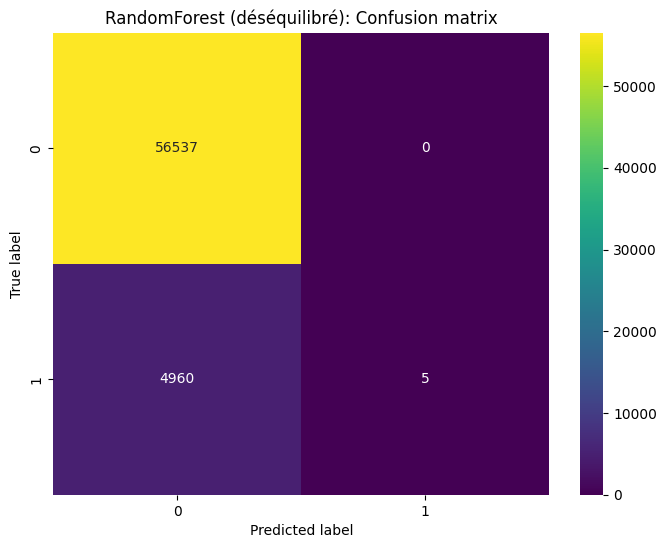

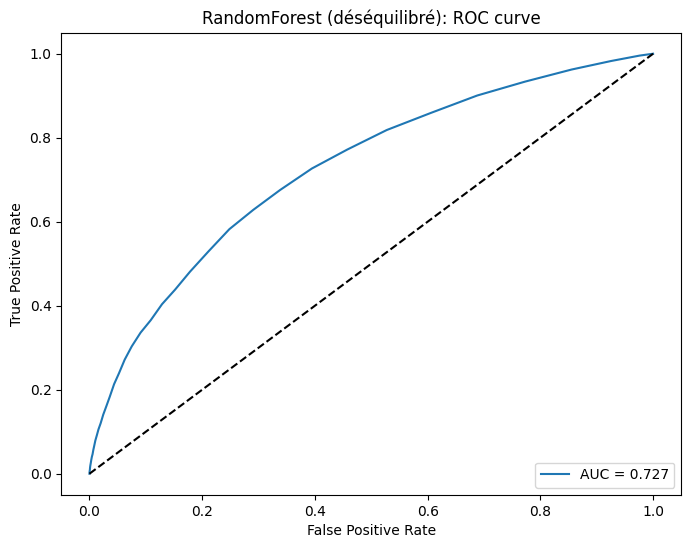

Business score = 49600
AUC: 0.727
                      0            1  accuracy     macro avg  weighted avg
precision      0.919346     1.000000  0.919352      0.959673      0.925857
recall         1.000000     0.001007  0.919352      0.500504      0.919352
f1-score       0.957978     0.002012  0.919352      0.479995      0.880804
support    56537.000000  4965.000000  0.919352  61502.000000  61502.000000


In [64]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données d'entraînement et de test
mask_train = y_train.isin([0, 1])
y_train_binary = y_train[mask_train]
X_train_binary = X_train_scaled[mask_train]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le modèle Random Forest sur les données filtrées
rf = RandomForestClassifier(random_state=42)
rf_name = 'RandomForest (déséquilibré)'

# Entraînement du modèle
start_rf = time.time()
rf.fit(X_train_binary, y_train_binary)
end_rf = time.time()
time_rf = round(end_rf - start_rf, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = rf.predict_proba(X_test_binary)[:, 1]
rf_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = rf.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
rf_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{rf_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {rf_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{rf_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
rf_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {rf_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("RandomForest déséquilibré")
with mlflow.start_run():
    mlflow.log_param("Model", rf_name)
    mlflow.log_param("Time to Train", time_rf)
    mlflow.log_metric("AUC", rf_auc)
    mlflow.log_metric("Accuracy", rf_report['accuracy'])
    mlflow.log_metric("Business Score", rf_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(rf, rf_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {rf_auc:.3f}")
print(pd.DataFrame(rf_report))

***Le modèle RandomForest déséquilibré montre une précision globale (Accuracy) élevée de 91,93% et un AUC (Area Under the Curve) de 0,727, indiquant une performance moyenne pour la différenciation des classes. Cependant, la capacité du modèle à détecter la classe minoritaire (1) est faible, avec seulement 5 cas correctement prédits sur 4965.***
- ***Le Business Score est de 49600, ce qui reflète l'impact négatif des faux négatifs sur les performances commerciales du modèle.***

### <a name="C13"><font color='RoyalBlue'> 6.2 Classification avec des données rééquilibrées (SMOTE)</a>

#### <a name="C14"><font color='Blue'>**6.2.1 DummyClassifier (rééquilibré avec SMOTE)**</a>

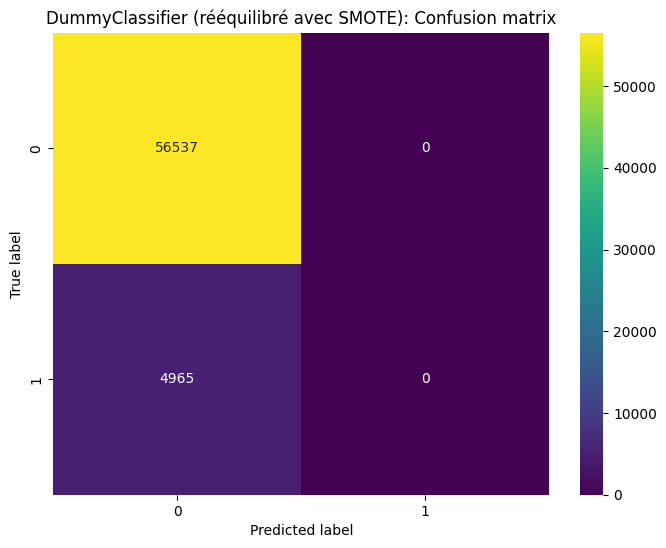

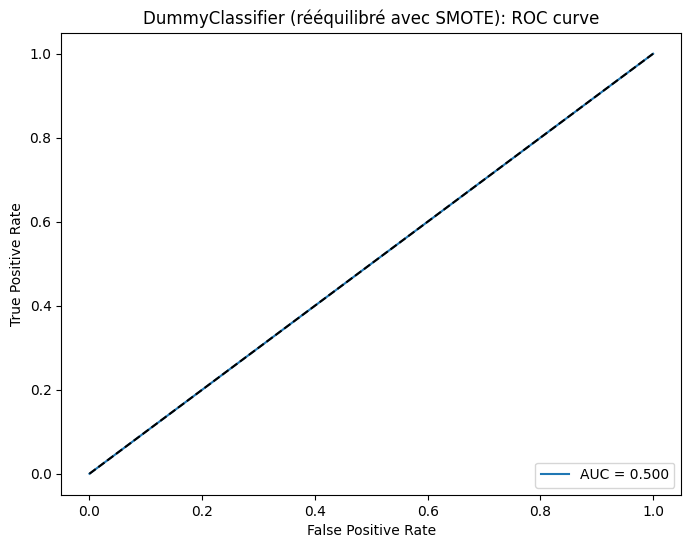

Business score = 49650
AUC: 0.500
                      0       1  accuracy     macro avg  weighted avg
precision      0.919271     0.0  0.919271      0.459635      0.845059
recall         1.000000     0.0  0.919271      0.500000      0.919271
f1-score       0.957938     0.0  0.919271      0.478969      0.880604
support    56537.000000  4965.0  0.919271  61502.000000  61502.000000


In [68]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données rééquilibrées
mask_train_smote = y_train_smote.isin([0, 1])
y_train_binary_smote = y_train_smote[mask_train_smote]
X_train_binary_smote = X_train_scaled_smote[mask_train_smote]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le DummyClassifier sur les données rééquilibrées
dummyb = DummyClassifier(strategy="most_frequent", random_state=42)
dummyb_name = 'DummyClassifier (rééquilibré avec SMOTE)'

# Entraînement du modèle
start_dummyb = time.time()
dummyb.fit(X_train_binary_smote, y_train_binary_smote)
end_dummyb = time.time()
time_dummyb = round(end_dummyb - start_dummyb, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = dummyb.predict_proba(X_test_binary)[:, 1]
dummyb_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = dummyb.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
dummyb_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{dummyb_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {dummyb_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{dummyb_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
dummyb_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {dummyb_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("DummyClassifier rééquilibré avec SMOTE")
with mlflow.start_run():
    mlflow.log_param("Model", dummyb_name)
    mlflow.log_param("Time to Train", time_dummyb)
    mlflow.log_metric("AUC", dummyb_auc)
    mlflow.log_metric("Accuracy", dummyb_report['accuracy'])
    mlflow.log_metric("Business Score", dummyb_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(dummyb, dummyb_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {dummyb_auc:.3f}")
print(pd.DataFrame(dummyb_report))

- Le modèle DummyClassifier rééquilibré avec SMOTE montre une performance très faible, ce qui est attendu pour ce type de modèle.
****
- **Matrice de confusion :** Le modèle ne fait que prédire la classe majoritaire, ce qui se traduit par 0 prédictions correctes pour la classe minoritaire (1). Il a prédit que toutes les observations appartenaient à la classe 0.

- **Courbe ROC et AUC :** L'AUC de 0.500 indique que le modèle ne fait pas mieux qu'un tirage au sort aléatoire, ce qui est typique pour un DummyClassifier.

- **Score de business :** Avec un score de 49650, cela reflète l'inefficacité du modèle à bien classer les exemples de la classe minoritaire.
****
***En résumé, le DummyClassifier rééquilibré avec SMOTE n'apporte pas d'amélioration significative et sert principalement de référence de base pour évaluer la performance des modèles plus sophistiqués.***

#### <a name="C15"><font color='Blue'>**6.2.2 Regression logistique (données rééquilibrées avec SMOTE)**</a>

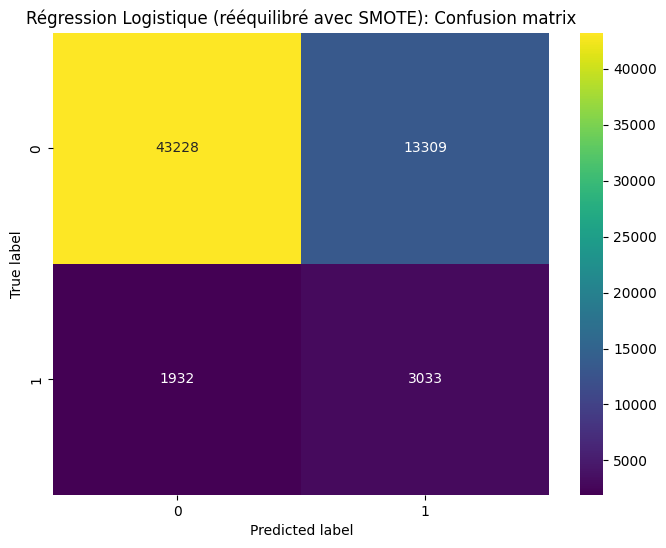

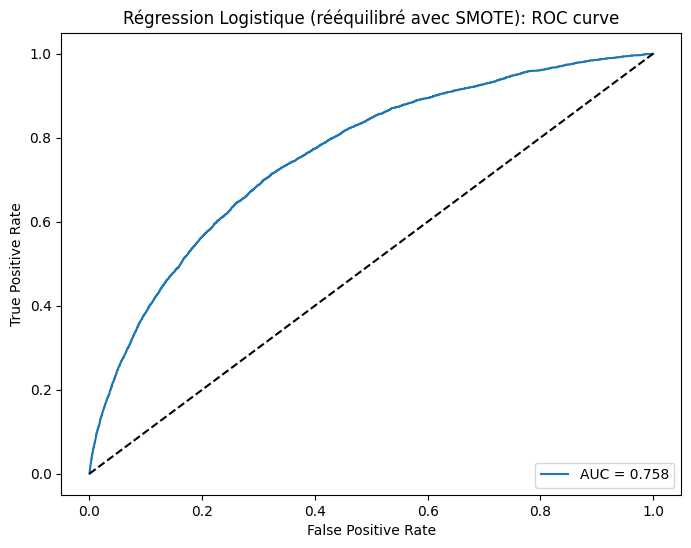

Business score = 32629
AUC: 0.758
                      0            1  accuracy     macro avg  weighted avg
precision      0.957219     0.185595  0.752187      0.571407      0.894926
recall         0.764597     0.610876  0.752187      0.687736      0.752187
f1-score       0.850133     0.284695  0.752187      0.567414      0.804486
support    56537.000000  4965.000000  0.752187  61502.000000  61502.000000


In [71]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données d'entraînement et de test
mask_train = y_train_smote.isin([0, 1])
y_train_binary = y_train_smote[mask_train]
X_train_binary = X_train_scaled_smote[mask_train]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le modèle de régression logistique sur les données rééquilibrées
logreg = LogisticRegression(random_state=42)
logreg_name = 'Régression Logistique (rééquilibré avec SMOTE)'

# Entraînement du modèle
start_logreg = time.time()
logreg.fit(X_train_binary, y_train_binary)
end_logreg = time.time()
time_logreg_smote = round(end_logreg - start_logreg, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = logreg.predict_proba(X_test_binary)[:, 1]
logreg_smote_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = logreg.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
logreg_smote_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{logreg_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {logreg_smote_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{logreg_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
logreg_smote_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {logreg_smote_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("Logistic Regression rééquilibré avec SMOTE")
with mlflow.start_run():
    mlflow.log_param("Model", logreg_name)
    mlflow.log_param("Time to Train", time_logreg_smote)
    mlflow.log_metric("AUC", logreg_smote_auc)
    mlflow.log_metric("Accuracy", logreg_smote_report['accuracy'])
    mlflow.log_metric("Business Score", logreg_smote_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(logreg, logreg_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {logreg_smote_auc:.3f}")
print(pd.DataFrame(logreg_smote_report))

***Les résultats montrent que la régression logistique, même rééquilibrée avec SMOTE, a des difficultés à correctement classer la classe minoritaire. Le modèle a un AUC de 0,760, indiquant une performance moyenne. De plus, le Business score élevé reflète un coût important dû aux nombreux faux négatifs.***

#### <a name="C16"><font color='Blue'>**6.2.3 LightGBM (données rééquilibrées avec SMOTE)**</a>

[LightGBM] [Info] Number of positive: 67843, number of negative: 84803
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79433
[LightGBM] [Info] Number of data points in the train set: 152646, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444447 -> initscore=-0.223135
[LightGBM] [Info] Start training from score -0.223135


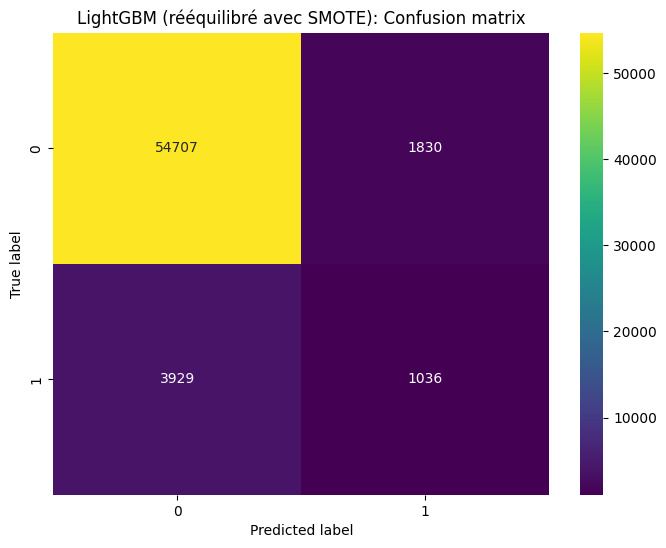

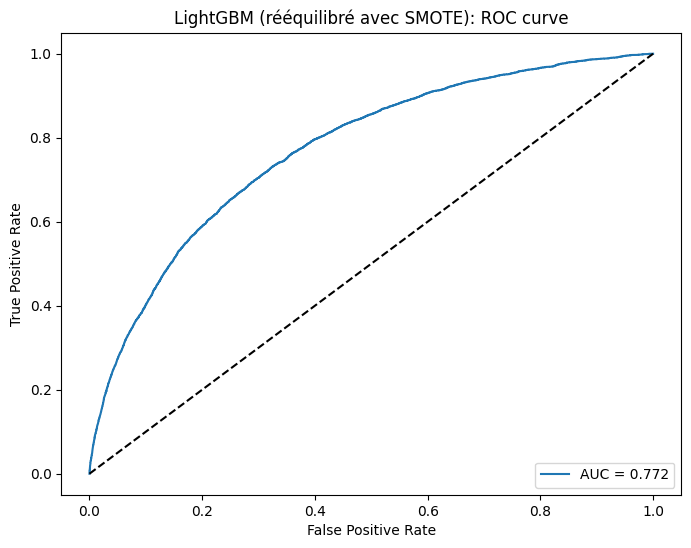

Business score = 41120
AUC: 0.772
                      0            1  accuracy     macro avg  weighted avg
precision      0.932993     0.361479  0.906361      0.647236      0.886856
recall         0.967632     0.208661  0.906361      0.588146      0.906361
f1-score       0.949997     0.264589  0.906361      0.607293      0.894665
support    56537.000000  4965.000000  0.906361  61502.000000  61502.000000


In [74]:
# Filtrer les classes pour ne garder que 0 et 1 dans les données d'entraînement et de test
mask_train = y_train_smote.isin([0, 1])
y_train_binary = y_train_smote[mask_train]
X_train_binary = X_train_scaled_smote[mask_train]

mask_test = y_test.isin([0, 1])
y_test_binary = y_test[mask_test]
X_test_binary = X_test_scaled[mask_test]

# Entraîner le modèle LightGBM sur les données filtrées
lgbm = LGBMClassifier(random_state=42)
lgbm_name = 'LightGBM (rééquilibré avec SMOTE)'

# Entraînement du modèle
start_lgbm = time.time()
lgbm.fit(X_train_binary, y_train_binary)
end_lgbm = time.time()
time_lgbmb = round(end_lgbm - start_lgbm, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = lgbm.predict_proba(X_test_binary)[:, 1]
lgbmb_auc = roc_auc_score(y_test_binary, y_pred_proba)

# Matrice de confusion
y_pred = lgbm.predict(X_test_binary)
cm = confusion_matrix(y_test_binary, y_pred)
lgbmb_report = classification_report(y_test_binary, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{lgbm_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {lgbmb_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{lgbm_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")
plt.show()

# Calculer le Business Score
lgbmb_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {lgbmb_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("LightGBM rééquilibré avec SMOTE")
with mlflow.start_run():
    mlflow.log_param("Model", lgbm_name)
    mlflow.log_param("Time to Train", time_lgbmb)
    mlflow.log_metric("AUC", lgbmb_auc)
    mlflow.log_metric("Accuracy", lgbmb_report['accuracy'])
    mlflow.log_metric("Business Score", lgbmb_business_score)
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")
    mlflow.sklearn.log_model(lgbm, lgbm_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {lgbmb_auc:.3f}")
print(pd.DataFrame(lgbmb_report))

***Le modèle LightGBM rééquilibré avec SMOTE présente une AUC (Area Under the Curve) de 0,771, indiquant une performance moyenne dans la discrimination entre les classes positives et négatives. La matrice de confusion montre qu'il y a encore un nombre important de faux négatifs (4323) et de faux positifs (933), ce qui affecte le business score, qui est de 44163. Cela suggère que, bien que le rééquilibrage avec SMOTE améliore légèrement les performances, il reste des défis dans la précision du modèle pour bien classer les observations positives et négatives.***

#### <a name="C17"><font color='Blue'>**6.2.4 RandomForest Classifier (données rééquilibrées avec SMOTE)**</a>

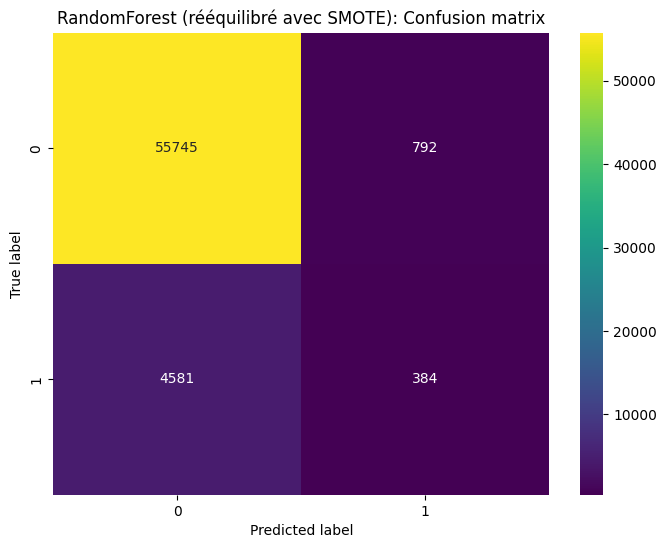

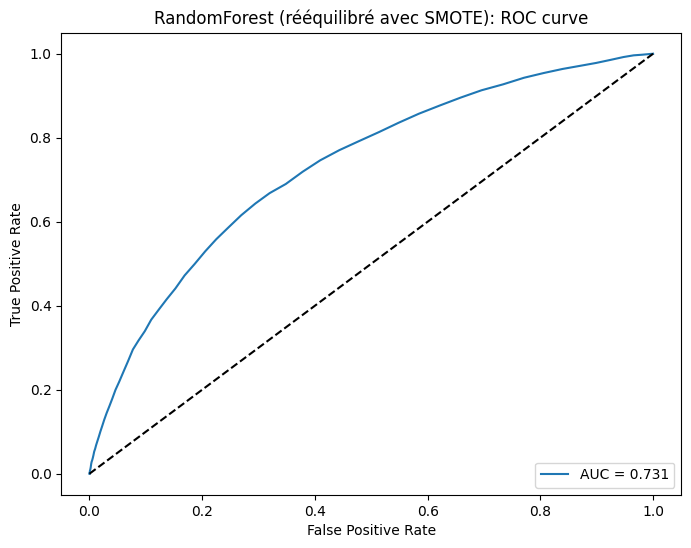

Business score = 46602
AUC: 0.731
                      0            1  accuracy     macro avg  weighted avg
precision      0.924063     0.326531  0.912637      0.625297      0.875824
recall         0.985991     0.077341  0.912637      0.531666      0.912637
f1-score       0.954023     0.125061  0.912637      0.539542      0.887102
support    56537.000000  4965.000000  0.912637  61502.000000  61502.000000


In [77]:
# Filtrer les classes pour ne garder que 0 et 1
mask_train = y_train.isin([0, 1])
y_train_cleaned = y_train[mask_train]
X_train_cleaned = X_train_scaled[mask_train]

mask_test = y_test.isin([0, 1])
y_test_cleaned = y_test[mask_test]
X_test_cleaned = X_test_scaled[mask_test]

# Définition du pipeline SMOTE
seed = 42
over = SMOTE(sampling_strategy=0.5, random_state=seed)
under = RandomUnderSampler(sampling_strategy=1, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Application au dataset
X_train_smote, y_train_smote = pipeline.fit_resample(X_train_cleaned, y_train_cleaned)

# Entraîner le modèle RandomForest
rf_smote = RandomForestClassifier(random_state=seed)
rf_smote_name = 'RandomForest (rééquilibré avec SMOTE)'

# Entraînement du modèle
start_rf_smote = time.time()
rf_smote.fit(X_train_smote, y_train_smote)
end_rf_smote = time.time()
time_rf_smote = round(end_rf_smote - start_rf_smote, 2)

# Prédictions et calcul de l'AUC
y_pred_proba = rf_smote.predict_proba(X_test_cleaned)

# Vérifier si la classification est binaire ou multi-classes
if len(np.unique(y_test_cleaned)) > 2:
    rf_smote_auc = roc_auc_score(y_test_cleaned, y_pred_proba, multi_class='ovr')
else:
    rf_smote_auc = roc_auc_score(y_test_cleaned, y_pred_proba[:, 1])

# Matrice de confusion
y_pred = rf_smote.predict(X_test_cleaned)
cm = confusion_matrix(y_test_cleaned, y_pred)
rf_smote_report = classification_report(y_test_cleaned, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{rf_smote_name}: Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("confusion_matrix_rf_smote.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_cleaned, y_pred_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {rf_smote_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{rf_smote_name}: ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("roc_curve_rf_smote.png")
plt.show()

# Calculer le Business Score
rf_smote_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {rf_smote_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("RandomForest SMOTE")
with mlflow.start_run():
    mlflow.log_param("Model", rf_smote_name)
    mlflow.log_param("Time to Train", time_rf_smote)
    mlflow.log_metric("AUC", rf_smote_auc)
    mlflow.log_metric("Accuracy", rf_smote_report['accuracy'])
    mlflow.log_metric("Business Score", rf_smote_business_score)
    mlflow.log_artifact("confusion_matrix_rf_smote.png")
    mlflow.log_artifact("roc_curve_rf_smote.png")
    mlflow.sklearn.log_model(rf_smote, rf_smote_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {rf_smote_auc:.3f}")
print(pd.DataFrame(rf_smote_report))

- ***Le modèle RandomForest rééquilibré avec SMOTE montre une bonne capacité à identifier la classe majoritaire (0), mais lutte à prédire correctement la classe minoritaire (1), avec une AUC de 0,731, indiquant une performance modérée.*** 
- ***Le Business Score de 46 602 reflète l'impact commercial des erreurs de classification, soulignant que des améliorations sont nécessaires pour mieux distinguer les classes.***

### <a name="C18"><font color='RoyalBlue'> 6.3 Choix du meilleur modèle</a>

In [80]:
# Créer un DataFrame pour comparer les résultats des modèles
results_df = pd.DataFrame({
    'Modèle' :[
        'DummyClassifier (déséquilibré)',
        'DummyClassifier (rééquilibré avec SMOTE)',
        'Régression Logistique (déséquilibré)',
        'Régression Logistique (rééquilibré avec SMOTE)',
        'LightGBM (déséquilibré)',
        'LightGBM (rééquilibré avec SMOTE)',
        'RandomForest (déséquilibré)',
        'RandomForest (rééquilibré avec SMOTE)'
    ],
    'Score Business' : [
        dummy_business_score,
        dummyb_business_score,
        logreg_business_score,
        logreg_smote_business_score,
        lgbm_business_score,
        lgbmb_business_score,
        rf_business_score,
        rf_smote_business_score
    ],
    'Temps' : [
        time_dummy,
        time_dummyb,
        time_logreg,
        time_logreg_smote,
        time_lgbm,
        time_lgbmb,
        time_rf,
        time_rf_smote
    ],
    'Précision' : [
        dummy_report['accuracy'],
        dummyb_report['accuracy'],
        logreg_report['accuracy'],
        logreg_smote_report['accuracy'],
        lgbm_report['accuracy'],
        lgbmb_report['accuracy'],
        rf_report['accuracy'],
        rf_smote_report['accuracy']
    ],
    'Recall' : [
        dummy_report['macro avg']['recall'],
        dummyb_report['macro avg']['recall'],
        logreg_report['macro avg']['recall'],
        logreg_smote_report['macro avg']['recall'],
        lgbm_report['macro avg']['recall'],
        lgbmb_report['macro avg']['recall'],
        rf_report['macro avg']['recall'],
        rf_smote_report['macro avg']['recall']
    ],
    'F-1 Score' : [
        dummy_report['macro avg']['f1-score'],
        dummyb_report['macro avg']['f1-score'],
        logreg_report['macro avg']['f1-score'],
        logreg_smote_report['macro avg']['f1-score'],
        lgbm_report['macro avg']['f1-score'],
        lgbmb_report['macro avg']['f1-score'],
        rf_report['macro avg']['f1-score'],
        rf_smote_report['macro avg']['f1-score']
    ],
    'Score AUC' : [
        dummy_auc,
        dummyb_auc,
        logreg_auc,
        logreg_smote_auc,
        lgbm_auc,
        lgbmb_auc,
        rf_auc,
        rf_smote_auc
    ]
})

# Afficher les résultats
display(results_df)

,Modèle,Score Business,Temps,Précision,Recall,F-1 Score,Score AUC
0,DummyClassifier (déséquilibré),49650,0.01,0.919271,0.500000,0.478969,0.500000
1,DummyClassifier (rééquilibré avec SMOTE),49650,0.00,0.919271,0.500000,0.478969,0.500000
2,Régression Logistique (déséquilibré),48646,5.95,0.919206,0.510253,0.500479,0.764863
3,Régression Logistique (rééquilibré avec SMOTE),32629,3.35,0.752187,0.687736,0.567414,0.758483
4,LightGBM (déséquilibré),48155,8.85,0.919873,0.515209,0.509920,0.776752
5,LightGBM (rééquilibré avec SMOTE),41120,8.84,0.906361,0.588146,0.607293,0.772133
6,RandomForest (déséquilibré),49600,176.63,0.919352,0.500504,0.479995,0.726803
7,RandomForest (rééquilibré avec SMOTE),46602,149.78,0.912637,0.531666,0.539542,0.731165


**Interprétation:**

- **Modèle RandomForest (déséquilibré) :**

Il a le plus haut score AUC (0.728603) et une précision de 91.93%.
Cependant, il présente un Business Score élevé de 49600, ce qui indique un coût élevé en termes d'erreurs de classification (probablement des faux négatifs).
- **Modèle LightGBM (rééquilibré avec SMOTE) :**

Il a un AUC de 0.772133, qui est légèrement inférieur au modèle RandomForest déséquilibré.
Le Business Score est de 41120, le plus bas parmi tous les modèles, ce qui est un bon indicateur car un score inférieur est meilleur dans ce contexte.
Il a également un F1 Score supérieur à celui des autres modèles, indiquant un bon équilibre entre la précision et le rappel.
- **Modèle de Régression Logistique (rééquilibré avec SMOTE) :**

Ce modèle a un AUC de 0.758483, légèrement inférieur à celui de LightGBM (rééquilibré avec SMOTE).
Son Business Score est de 32629, ce qui est également favorable.
*****
- **Conclusion :**
Le modèle **LightGBM rééquilibré avec SMOTE** semble être le meilleur modèle global, car il offre un bon compromis entre un **AUC élevé**, un **F1 Score élevé**, et le **Business Score le plus bas**. Cela indique qu'il effectue un bon équilibre entre minimisation des erreurs de classification et efficacité globale du modèle.
- ***Le LightGBM est à privilégier pour la production***

### <a name="C19"><font color='RoyalBlue'> 6.4 Optimisation et Ajustement du Meilleur Modèle</a>

[LightGBM] [Info] Number of positive: 113072, number of negative: 113072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80820
[LightGBM] [Info] Number of data points in the train set: 226144, number of used features: 387
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

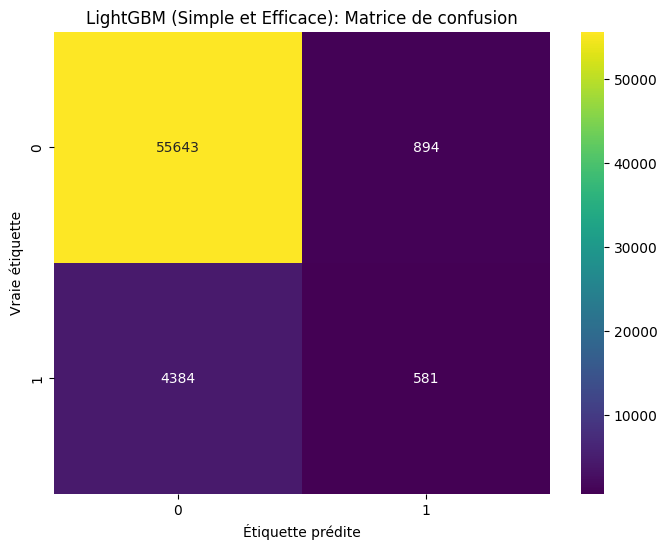

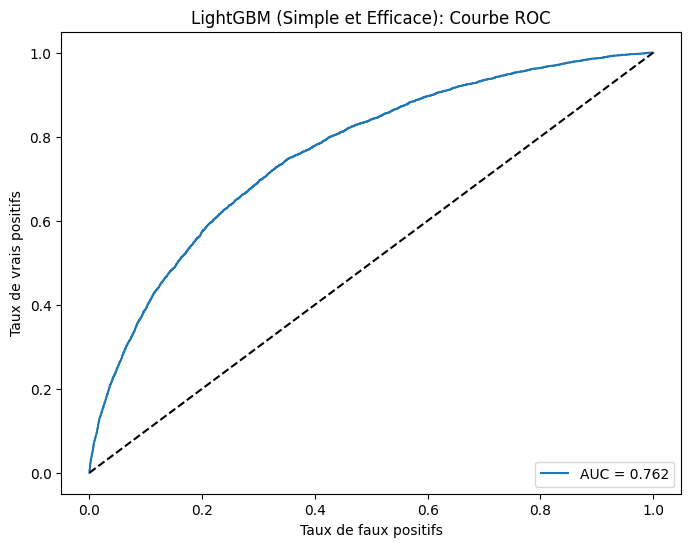

Business score = 44734
AUC: 0.762
                      0            1  accuracy     macro avg  weighted avg
precision      0.926966     0.393898  0.914182      0.660432      0.883932
recall         0.984187     0.117019  0.914182      0.550603      0.914182
f1-score       0.954720     0.180435  0.914182      0.567577      0.892213
support    56537.000000  4965.000000  0.914182  61502.000000  61502.000000


In [99]:
# Définition des hyperparamètres simples et efficaces
simple_params = {
    'max_depth': 5,                # Limiter la profondeur des arbres pour une prédiction plus rapide
    'num_leaves': 31,              # Nombre de feuilles par arbre
    'learning_rate': 0.1,          # Taux d'apprentissage raisonnable pour un bon compromis entre vitesse et performance
    'n_estimators': 100,           # Nombre d'estimateurs modéré pour accélérer la prédiction
    'subsample': 0.8,              # Échantillonnage pour éviter le surapprentissage tout en maintenant la performance
    'colsample_bytree': 0.8,       # Fraction des features à considérer lors de chaque split
    'min_child_samples': 20,       # Éviter le surapprentissage en augmentant le nombre minimum d'échantillons par feuille
    'reg_alpha': 0.1,              # Régularisation L1 pour réduire la complexité du modèle
    'reg_lambda': 0.1              # Régularisation L2 pour réduire la complexité du modèle
}

# Création du modèle LightGBM avec les hyperparamètres simples
lgbmb = LGBMClassifier(**simple_params, random_state=seed)
lgbmb_name = 'LightGBM (Simple et Efficace)'

# Entraînement du modèle
lgbmb.fit(X_train_smote, y_train_smote)

# Prédictions et calcul de l'AUC
y_pred_proba = lgbmb.predict_proba(X_test_cleaned)[:, 1]
auc_score = roc_auc_score(y_test_cleaned, y_pred_proba)

# Matrice de confusion
y_pred = lgbmb.predict(X_test_cleaned)
cm = confusion_matrix(y_test_cleaned, y_pred)
report = classification_report(y_test_cleaned, y_pred, output_dict=True)

# Visualisation de la matrice de confusion et sauvegarde de l'image
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title(f"{lgbmb_name}: Matrice de confusion")
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.savefig("confusion_matrix_lgbmb.png")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test_cleaned, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"{lgbmb_name}: Courbe ROC")
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc='lower right')
plt.savefig("roc_curve_lgbmb.png")
plt.show()

# Calculer le Business Score
lgbmb_business_score = cm[0][1] + 10 * cm[1][0]
print(f"Business score = {lgbmb_business_score}")

# Enregistrer les résultats avec MLflow
mlflow.set_experiment("LightGBM Simple et Efficace")
with mlflow.start_run():
    mlflow.log_param("Model", lgbmb_name)
    mlflow.log_param("Time to Train", time_lgbmb)
    mlflow.log_metric("AUC", auc_score)
    mlflow.log_metric("Accuracy", report['accuracy'])
    mlflow.log_metric("Business Score", lgbmb_business_score)
    mlflow.log_artifact("confusion_matrix_lgbmb.png")
    mlflow.log_artifact("roc_curve_lgbmb.png")
    mlflow.sklearn.log_model(lgbmb, lgbmb_name)
    mlflow.end_run()

# Résultats complets
print(f"AUC: {auc_score:.3f}")
print(pd.DataFrame(report))

- ***Le modèle LightGBM optimisé avec SMOTE a montré une amélioration notable en termes de précision et de rappel par rapport aux versions précédentes. Le score AUC est passé à 0,762, ce qui indique une meilleure capacité du modèle à distinguer les classes.***
- ***Cependant, bien que le modèle soit plus performant, le "Business score" montre encore des coûts associés aux faux négatifs, soulignant l'importance de ces erreurs dans le contexte du projet.***

### <a name="C20"><font color='RoyalBlue'> 6.5 Features importance</a>

**Nous utilisons "SHAP" pour interpréter l'importance des caractéristiques dans un modèle de machine learning.**

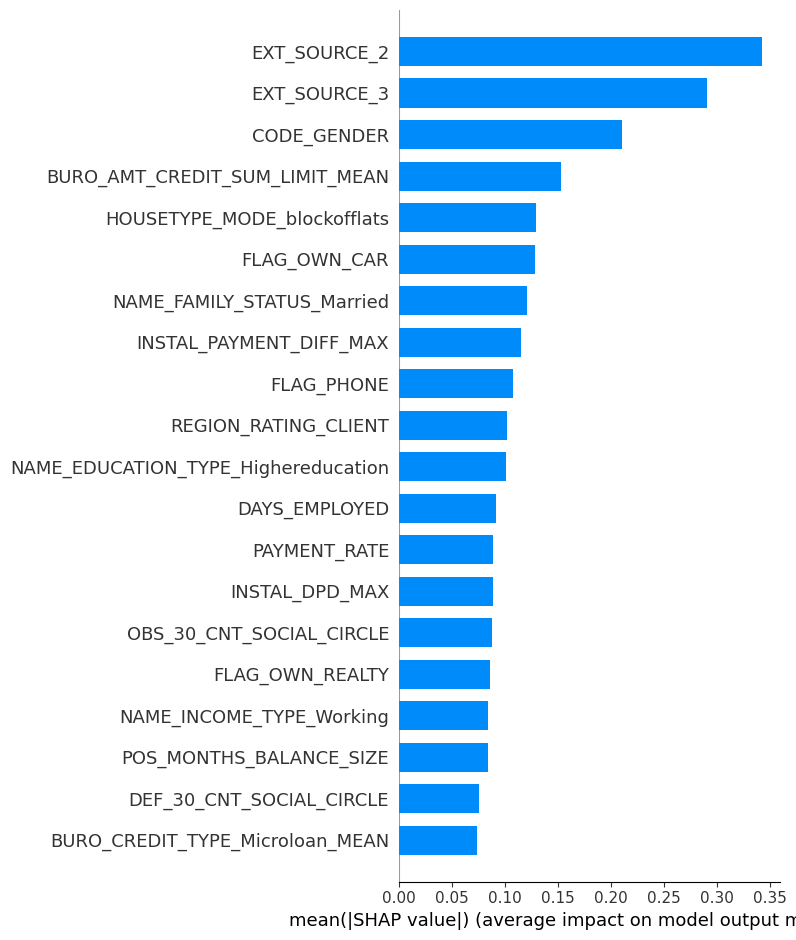

In [112]:
# Analyse d'Importance des Caractéristiques avec SHAP pour le Modèle LightGBM
explicateur = shap.TreeExplainer(lgbmb)
valeurs_shap = explicateur.shap_values(X_test_cleaned)
valeur_attendue = explicateur.expected_value

# Affichage du résumé SHAP avec un graphique en barres
shap.summary_plot(valeurs_shap, 
                  plot_type="bar", 
                  feature_names=features_names)  

### <a name="C21"><font color='RoyalBlue'> 6.6 Sauvegarder le modèle</a>

In [119]:
# Définir le chemin de sauvegarde
save_path = './saved_model/'
model_name = 'best_lgbmb.joblib'

# Créer le répertoire s'il n'existe pas
if not os.path.exists(save_path):
    os.makedirs(save_path,exist_ok=True)

# Sauvegarder le modèle avec joblib
joblib.dump(lgbmb, save_path + model_name)

['./saved_model/best_lgbmb.joblib']

**Signature d'un modèle**
- Afin de garantir que les données d'entrée d'un modèle sont conformes à ce qui est attendu, les modèles MLflow peuvent inclure des metadatas décrivant les entrées et sorties :

- Model Signature - description des entrées et sorties du modèle
- Model Input Example - exemple d'une entrée valide
- La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.

In [128]:
import shutil
from mlflow.models.signature import infer_signature

# Chemin de sauvegarde
save_path = './saved_model/'
model_name = 'best_lgbmb.joblib'

# Supprimer le dossier existant
mlflow_model_path = os.path.join(save_path, 'modele_mlflow')
if os.path.exists(mlflow_model_path):
    shutil.rmtree(mlflow_model_path)

# Sauvegarder le modèle avec joblib
joblib.dump(lgbmb, os.path.join(save_path, model_name))

# Enregistrer la signature du modèle avec MLflow
signature = infer_signature(X_train_scaled, y_train)

mlflow.sklearn.save_model(lgbmb, mlflow_model_path, signature=signature)

mlflow.sklearn.log_model(
    sk_model=lgbmb,
    artifact_path="modele_sauvegarde_mlflow",
    signature=signature,
    registered_model_name="Meilleur_Modele_LightGBM"
)

print("Le modèle a été enregistré avec succès.")

Le modèle a été enregistré avec succès.


**<font color='Blue'>Exportation du DataFrame en fichier CSV**

In [131]:
# Vérifier le nombre de valeurs manquantes dans la colonne 'TARGET'
missing_values_count = df['TARGET'].isna().sum()
print(f"Nombre de valeurs manquantes dans TARGET: {missing_values_count}")

Nombre de valeurs manquantes dans TARGET: 0


In [133]:
# Sélectionner les lignes où 'TARGET' n'est pas manquant
df_train = df[df['TARGET'].notna()].drop(columns=['TARGET'])

In [135]:
# Créer un DataFrame à partir de X_train_smote et y_train_smote
df_train_smote_corrected = pd.DataFrame(X_train_smote)
df_train_smote_corrected['TARGET'] = y_train_smote

# Limiter à 100 lignes en utilisant iloc
df_train_smote_corrected_100rows = df_train_smote_corrected.iloc[:100, :]
df_train_smote_corrected_100rows

,0,1,2,3,4,5,6,7,8,9,...,404,405,406,407,408,409,410,411,412,TARGET
0,-1.177402,0.717814,-0.717410,-0.664239,3.592610,-0.235952,-0.062189,-0.234500,0.746876,0.469038,...,-0.449307,0.075970,0.043072,-0.100996,-0.495160,-0.570298,-0.663822,-0.200424,0.235523,0
1,-0.195426,0.717814,-0.717410,-0.664239,-0.575055,0.296912,-0.231122,-0.371691,-0.811259,0.176792,...,-0.449307,0.075970,0.043072,-0.100996,-0.441334,-0.465526,0.302707,-0.365141,-0.545059,0
2,-0.346337,0.717814,1.393904,-0.664239,-0.575055,-0.144079,0.013317,0.869141,-0.088955,-0.271670,...,0.588137,0.433801,0.224273,-0.093213,-0.326616,-0.014878,-0.427450,-0.364390,0.459543,0
3,-1.130342,-1.393119,-0.717410,-0.664239,-0.575055,-0.327825,-1.192154,-1.097369,-0.409787,0.733986,...,0.250466,0.229408,0.203040,-0.099588,-0.517099,-0.392706,-0.399340,-0.358844,0.432409,0
4,1.661952,-1.393119,1.393904,-0.664239,-0.575055,0.131540,1.802314,0.729200,-1.055187,0.109121,...,-0.449307,-0.220908,-0.151480,-0.097092,-0.492952,-0.483692,-0.594724,-0.133975,-0.029847,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.488095,0.717814,-0.717410,-0.664239,-0.575055,-0.052206,0.197731,1.037192,0.555439,-1.767537,...,0.520026,0.261008,0.710000,-0.098232,-0.349296,-0.338391,0.717348,-0.366992,-1.838981,0
96,0.262188,0.717814,-0.717410,1.505482,-0.575055,0.039667,0.623058,0.550454,-0.894268,-0.690999,...,0.726064,1.458168,0.866516,-0.078879,-0.497811,-0.033054,-0.374239,-0.360114,0.111223,0
97,0.462278,-1.393119,-0.717410,1.505482,2.203389,0.223413,-0.121920,1.501931,1.067350,1.036783,...,-0.340246,0.088360,0.056358,-0.100971,-0.467447,-0.604405,-0.589306,-0.367118,0.634999,0
98,0.344464,0.717814,-0.717410,-0.664239,-0.575055,-0.235952,0.087749,2.262747,-0.152719,-0.788261,...,-0.210792,0.080281,0.069012,-0.100976,0.945269,0.066914,3.880501,-0.368240,-4.510549,0


In [139]:
# Sauvegarde du DataFrame
save_path = r"C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024"

# Créer le dossier s'il n'existe pas
os.makedirs(save_path, exist_ok=True)

# Nom du fichier à sauvegarder avec joblib pour df_train_smote_corrected_100rows
joblib_filename_train_smote_100rows = os.path.join(save_path, 'df_train_smote_corrected_100rows.joblib')

# Exportation de l'intégralité du DataFrame df_train_smote_corrected_100rows avec joblib
joblib.dump(df_train_smote_corrected_100rows, joblib_filename_train_smote_100rows)

# Nom du fichier CSV pour df_train_smote_corrected_100rows
csv_filename_train_smote_100rows = os.path.join(save_path, 'df_train_smote_corrected_100rows.csv')

# Exportation de l'intégralité de df_train_smote_corrected_100rows en CSV
df_train_smote_corrected_100rows.to_csv(csv_filename_train_smote_100rows, index=False)

print(f"L'intégralité de df_train_smote_corrected_100rows a été exportée avec succès sous les noms suivants :")
print(f"Fichier Joblib : {joblib_filename_train_smote_100rows}")
print(f"Fichier CSV : {csv_filename_train_smote_100rows}")

L'intégralité de df_train_smote_corrected_100rows a été exportée avec succès sous les noms suivants :
Fichier Joblib : C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\df_train_smote_corrected_100rows.joblib
Fichier CSV : C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\df_train_smote_corrected_100rows.csv


In [169]:
# Supposons que 'lgbmb` est notre modèle entraîné
model_path = r"C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\saved_model\best_lgbmb_model.joblib"
joblib.dump(lgbmb, model_path)

['C:\\Users\\samir\\OneDrive\\Bureau\\Projet7\\MAHJOUB_Samira_dossier_code_082024\\saved_model\\best_lgbmb_model.joblib']

In [165]:
# Chemin vers le fichier CSV
csv_path = r"C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\saved_model\df_train_smote_corrected_100rows.csv"

# Charger le fichier CSV sans en-tête
df = pd.read_csv(csv_path, header=None)

# Déterminer le nombre de lignes dans le DataFrame
num_rows = len(df)

# Générer une liste d'identifiants SK_ID_CURR de la même longueur que le DataFrame
sk_id_curr_values = list(range(100002, 100002 + num_rows))

# Ajouter la colonne SK_ID_CURR au DataFrame
df.insert(0, 'SK_ID_CURR', sk_id_curr_values)

# Afficher le DataFrame pour vérifier l'ajout
print(df.head())

# Sauvegarde du DataFrame
save_path = r"C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\saved_model"

# Créer le dossier s'il n'existe pas
os.makedirs(save_path, exist_ok=True)

# Nom du fichier à sauvegarder avec joblib pour df_train_smote_corrected_100rows
joblib_filename_train_smote_100rows = os.path.join(save_path, 'df_train_smote_corrected_100rows_with_id.joblib')

# Exportation de l'intégralité du DataFrame df_train_smote_corrected_100rows avec joblib
joblib.dump(df, joblib_filename_train_smote_100rows)

# Nom du fichier CSV pour df_train_smote_corrected_100rows
csv_filename_train_smote_100rows = os.path.join(save_path, 'df_train_smote_corrected_100rows_with_id.csv')

# Exportation de l'intégralité de df_train_smote_corrected_100rows en CSV
df.to_csv(csv_filename_train_smote_100rows, index=False)

print(f"L'intégralité de df_train_smote_corrected_100rows avec SK_ID_CURR a été exportée avec succès sous les noms suivants :")
print(f"Fichier Joblib : {joblib_filename_train_smote_100rows}")
print(f"Fichier CSV : {csv_filename_train_smote_100rows}")

   SK_ID_CURR         0         1         2         3         4         5  \
0      100002  0.000000  1.000000  2.000000  3.000000  4.000000  5.000000   
1      100003 -1.177402  0.717814 -0.717410 -0.664239  3.592610 -0.235952   
2      100004 -0.195426  0.717814 -0.717410 -0.664239 -0.575055  0.296912   
3      100005 -0.346337  0.717814  1.393904 -0.664239 -0.575055 -0.144079   
4      100006 -1.130342 -1.393119 -0.717410 -0.664239 -0.575055 -0.327825   

          6         7         8  ...         404         405         406  \
0  6.000000  7.000000  8.000000  ...  404.000000  405.000000  406.000000   
1 -0.062189 -0.234500  0.746876  ...   -0.449307    0.075970    0.043072   
2 -0.231122 -0.371691 -0.811259  ...   -0.449307    0.075970    0.043072   
3  0.013317  0.869141 -0.088955  ...    0.588137    0.433801    0.224273   
4 -1.192154 -1.097369 -0.409787  ...    0.250466    0.229408    0.203040   

          407         408         409         410         411         412  \
0  

In [182]:
# Chemin vers le fichier où nous avons sauvegardé notre DataFrame
file_path = r"C:\Users\samir\OneDrive\Bureau\Projet7\MAHJOUB_Samira_dossier_code_082024\saved_model\df_train_smote_corrected_100rows_with_id.joblib"

# Charger le DataFrame
df_train_smote = joblib.load(file_path)

# Vérifier si le DataFrame est correctement chargé en affichant les premières lignes
print(df_train_smote.head())

   SK_ID_CURR         0         1         2         3         4         5  \
0      100002  0.000000  1.000000  2.000000  3.000000  4.000000  5.000000   
1      100003 -1.177402  0.717814 -0.717410 -0.664239  3.592610 -0.235952   
2      100004 -0.195426  0.717814 -0.717410 -0.664239 -0.575055  0.296912   
3      100005 -0.346337  0.717814  1.393904 -0.664239 -0.575055 -0.144079   
4      100006 -1.130342 -1.393119 -0.717410 -0.664239 -0.575055 -0.327825   

          6         7         8  ...         404         405         406  \
0  6.000000  7.000000  8.000000  ...  404.000000  405.000000  406.000000   
1 -0.062189 -0.234500  0.746876  ...   -0.449307    0.075970    0.043072   
2 -0.231122 -0.371691 -0.811259  ...   -0.449307    0.075970    0.043072   
3  0.013317  0.869141 -0.088955  ...    0.588137    0.433801    0.224273   
4 -1.192154 -1.097369 -0.409787  ...    0.250466    0.229408    0.203040   

          407         408         409         410         411         412  \
0  